# Aggregate by weights and by counts


We assign weights to the examples whose values are inversely proportional to the number of measures
reported by the corresponding cruise ID. If the cruise reports more measures, the measures are assigned
smaller weights, and vice versa.

In the following plots, **the first column** is the cummulative curve aggreagated **over the weights**,
and **the second column** is the one that aggregated **over the counts** (i.e. ignore the weights)

In [70]:
ls ../runs

first-run/           new-data-runs-2/     second-run/
new-data-runs-1/     new-data-runs-3/     third-run-no-geoloc/


In [67]:
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve


def get_margin_plot(scores0, weights0, scores1, weights1, labels, ax, legends=None, title=None, colors=['b', 'r']):
    y0 = np.cumsum(weights0) / np.sum(weights0)
    ax[0].plot(scores0, 1.0 - y0, colors[0], label=labels[0])
    ax[0].fill_between(scores0, 1.0 - y0, alpha=0.2, color=colors[0])
    y1 = np.cumsum(weights1) / np.sum(weights1)
    ax[0].plot(scores1, y1, colors[1], label=labels[1])
    ax[0].fill_between(scores1, y1, alpha=0.2, color=colors[1])
    ax[0].legend(loc=9)
    ax[0].set_xlabel('Margin Score')
    ax[0].set_ylabel('Weights %')
    if title:
        ax[0].set_title(title)

    y0 = np.cumsum(np.ones_like(weights0)) / weights0.shape[0]
    ax[1].plot(scores0, 1.0 - y0, colors[0], label=labels[0])
    ax[1].fill_between(scores0, 1.0 - y0, alpha=0.2, color=colors[0])
    y1 = np.cumsum(np.ones_like(weights1)) / weights1.shape[0]
    ax[1].plot(scores1, y1, colors[1], label=labels[1])
    ax[1].fill_between(scores1, y1, alpha=0.2, color=colors[1])
    ax[1].legend(loc=9)
    ax[1].set_xlabel('Margin Score')
    ax[1].set_ylabel('# Measures %')
    if title:
        ax[1].set_title(title)


def plot_scores(data, source):    
    _, labels, scores, weights = data
    scores0 = scores[labels == 0]
    weights0 = weights[labels == 0]
    order0 = np.argsort(scores0)
    scores0, weights0 = scores0[order0], weights0[order0]

    scores1 = scores[labels == 1]
    weights1 = weights[labels == 1]    
    order1 = np.argsort(scores1)
    scores1, weights1 = scores1[order1], weights1[order1]

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    # for i in range(10):
    get_margin_plot(scores0, weights0, scores1, weights1,
                    ["good", "bad"], ax, colors=_style)

    for i in range(len(ax)):
        ax[i].grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

    ax[0].set_title('%s aggr. by weights\ndata_size=%d' % (source, labels.shape[0]))
    ax[1].set_title('%s aggr. by counts\ndata_size=%d' % (source, labels.shape[0]))

    # fig.savefig("filename.pdf", format="pdf")




def get_precision_recall(labels, scores):
    num_pos = np.sum(labels == 1)
    num_neg = labels.shape[0] - num_pos
    precision, recall, thr = precision_recall_curve(labels, scores, pos_label=1)
    # auprc = auc(recall, precision)
    recall_neg = (1.0 - precision) * recall * num_pos / precision / num_neg
    return (precision, recall, thr, recall_neg)


def plot_prc(precision, recall, thr, recall_neg, get_label, ax):
    ax.plot(recall, precision)
    ax.set_xlim(0.0, 1.0)
    # ax.set_ylim(0.0, 1.0)

    scatter_x, scatter_y = [], []
    last_recall = 1.0
    for x, y, threshold, pn in zip(recall, precision, thr, recall_neg):
        if last_recall - x >= 0.1 or last_recall - x >= 0.05 and x >= 0.9:
            ax.annotate(get_label(threshold),
                         (x,y),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')
            ax.annotate("{:.2f}".format(pn),
                         (x,y),
                         textcoords="offset points",
                         xytext=(0,-18),
                         ha='center')
            scatter_x.append(x)
            scatter_y.append(y)
            last_recall = x

    ax.scatter(scatter_x, scatter_y)

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

    font = FontProperties()
    font.set_family("monospace")
    font.set_size(14)
    ax.text(0.03, 0.13, '>0.99  Threshold\n 0.02  False positive rate',
            transform=ax.transAxes, fontproperties=font,
            verticalalignment='top', bbox=dict(alpha=0.3));
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='1.0',)
    ax.grid(which='minor', linestyle=':', linewidth='1.0',);


def plot_edit_rescue(data, label):
    _, labels, scores, _ = data

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    precision, recall, thr, recall_neg = get_precision_recall(labels, scores)
    plot_prc(precision, recall, thr, recall_neg, lambda v: ">{:.2f}".format(v), ax[0])
    ax[0].set_title("Editing " + label)

    precision, recall, thr, recall_neg = get_precision_recall(1.0 - labels, 1.0 - scores)
    plot_prc(precision, recall, thr, recall_neg, lambda v: "<{:.2f}".format(1.0 - v), ax[1])
    ax[1].set_yscale("log")
    ax[1].set_ylabel("Precision (log scale)")
    ax[1].set_title("Rescue " + label)

    fig.tight_layout();

# Precision-Recall

In [3]:
run_name = "new-data-runs-1"
base_dir = "../runs/{}/runtime_scores".format(run_name)
_style = ['b', 'r']
sources = ["AGSO", "NGDC", "US_multi", "JAMSTEC", "NOAA_geodas", "NGA", "SIO"]

AGSO, NGDC, US_multi, JAMSTEC, NOAA_geodas, NGA, SIO, 

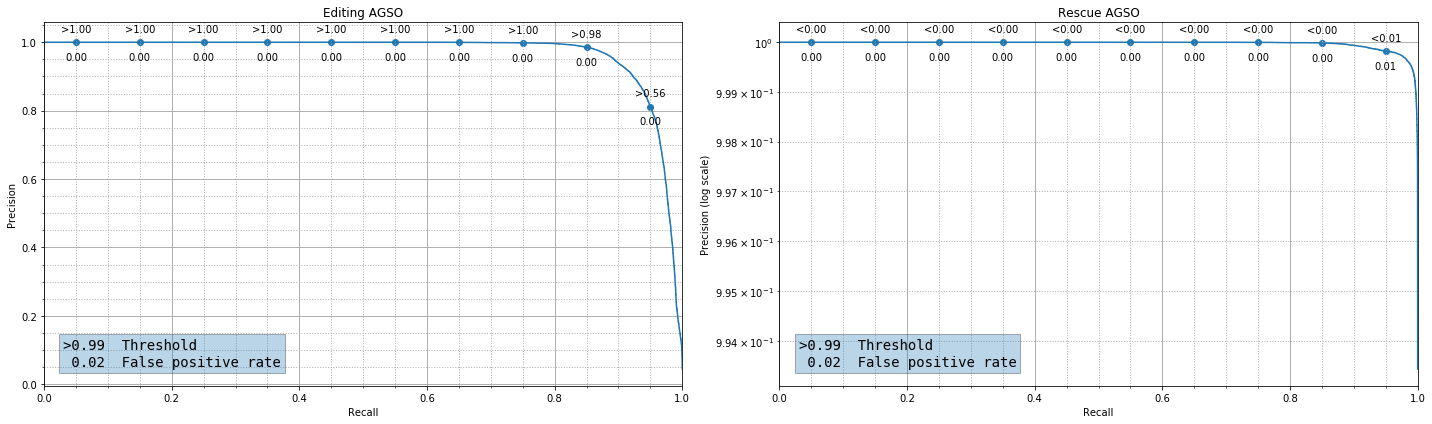

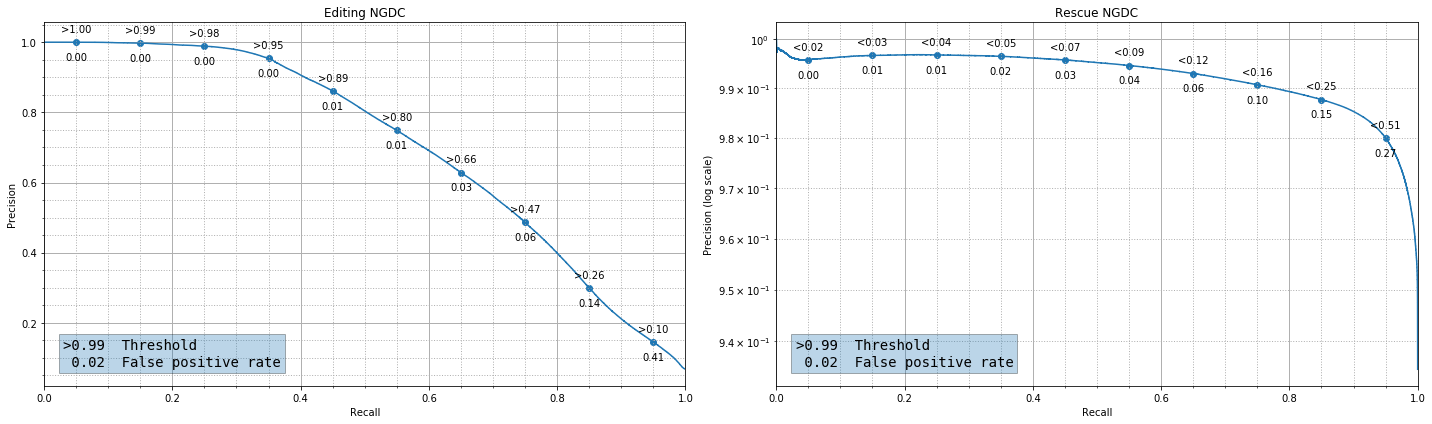

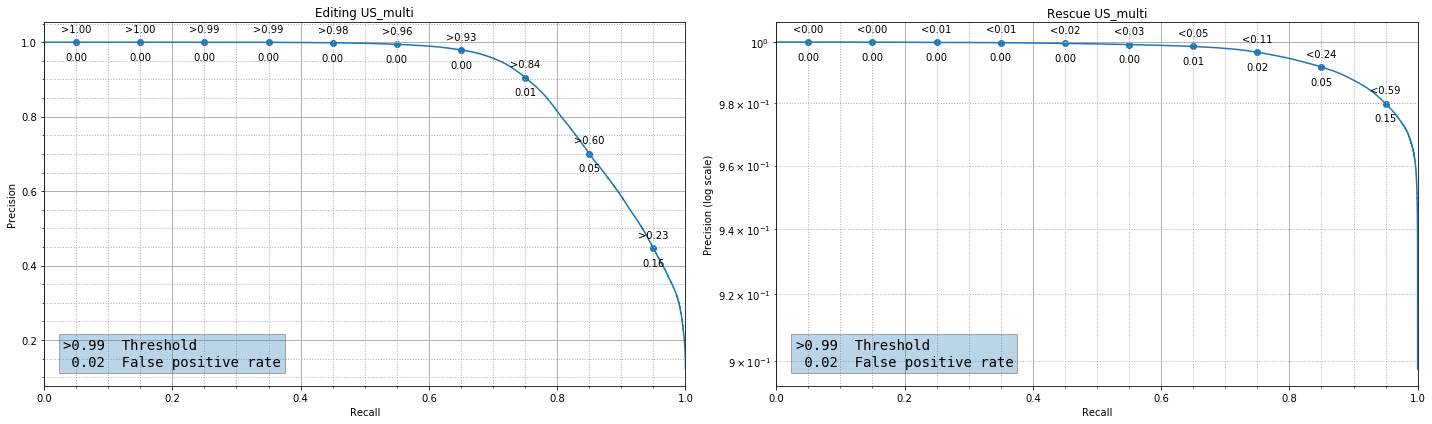

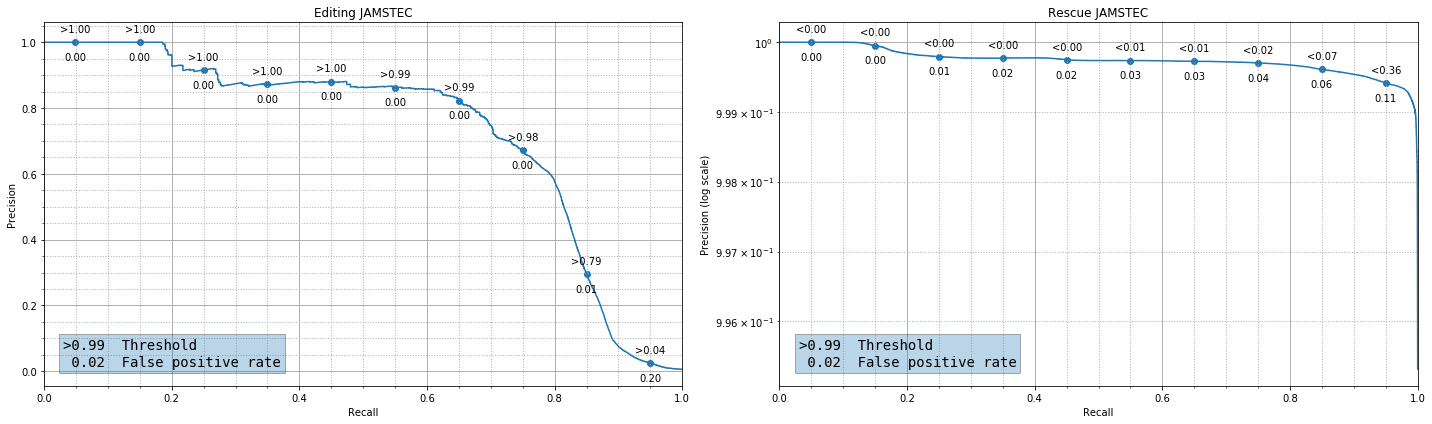

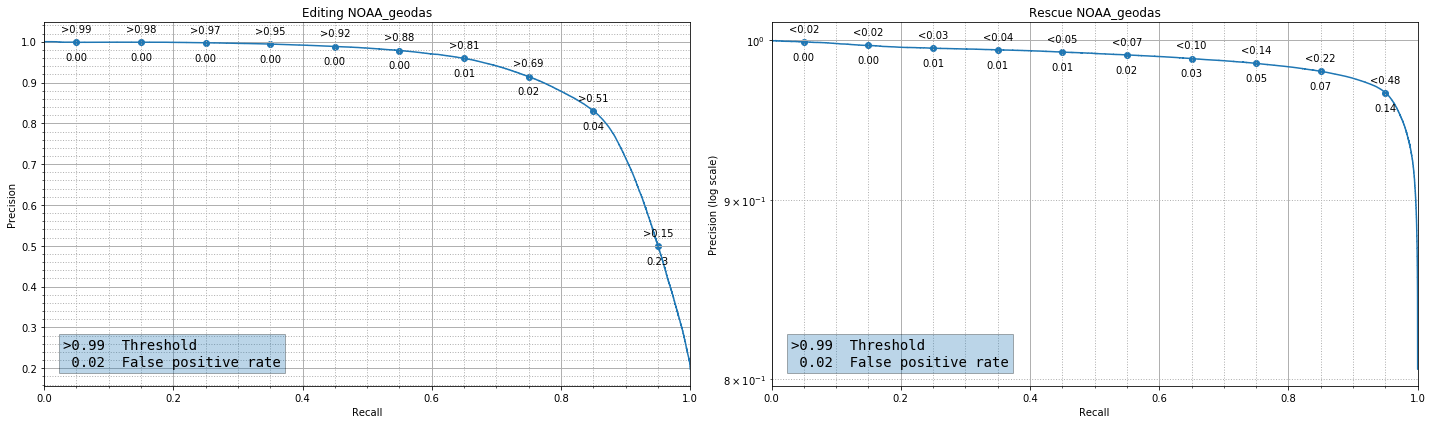

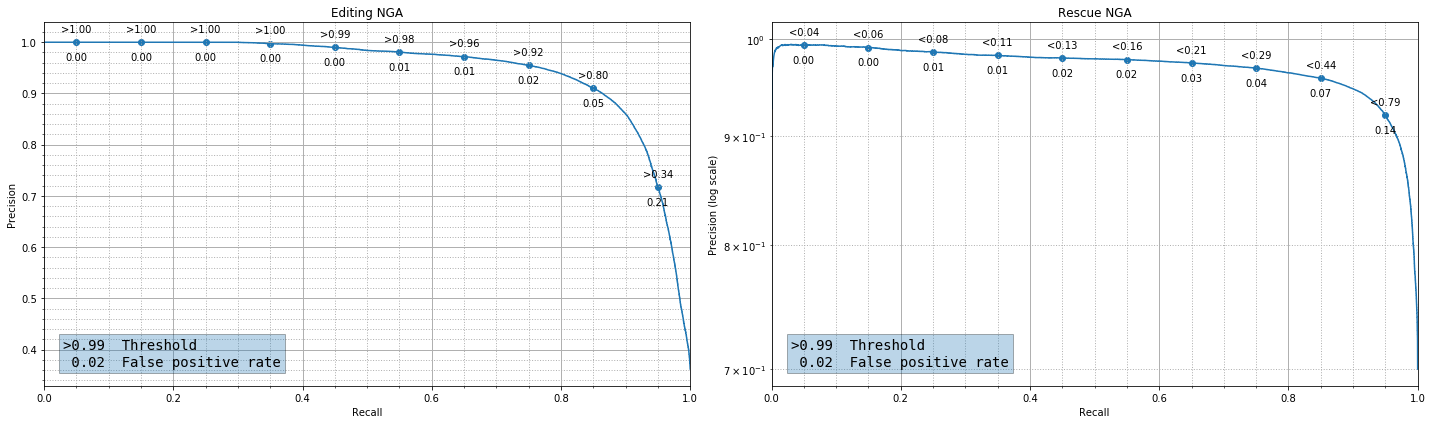

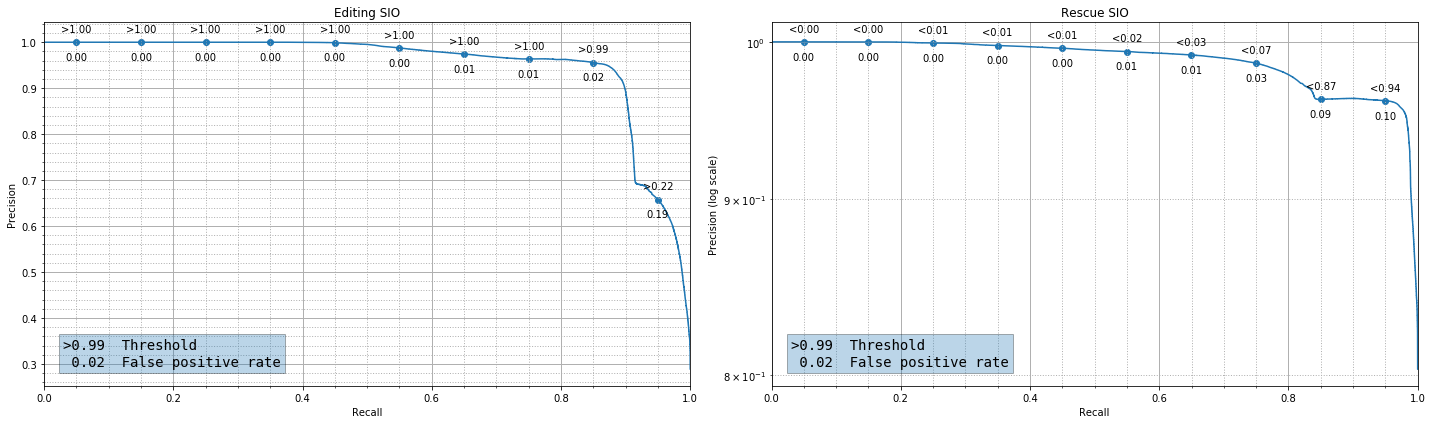

In [69]:
for source in sources:
    print(source, end=", ")
    path = os.path.join(base_dir, "{}_scores.pkl".format(source))
    with open(path, 'rb') as f:
        data = pickle.load(f)
    plot_edit_rescue(data, source)

# Scores CDF

Scores range	min 	max 
AGSO        	0.00	1.00
NGDC        	0.00	1.00
US_multi    	0.00	1.00
JAMSTEC     	0.00	1.00
NOAA_geodas 	0.00	1.00
NGA         	0.01	1.00
SIO         	0.00	1.00


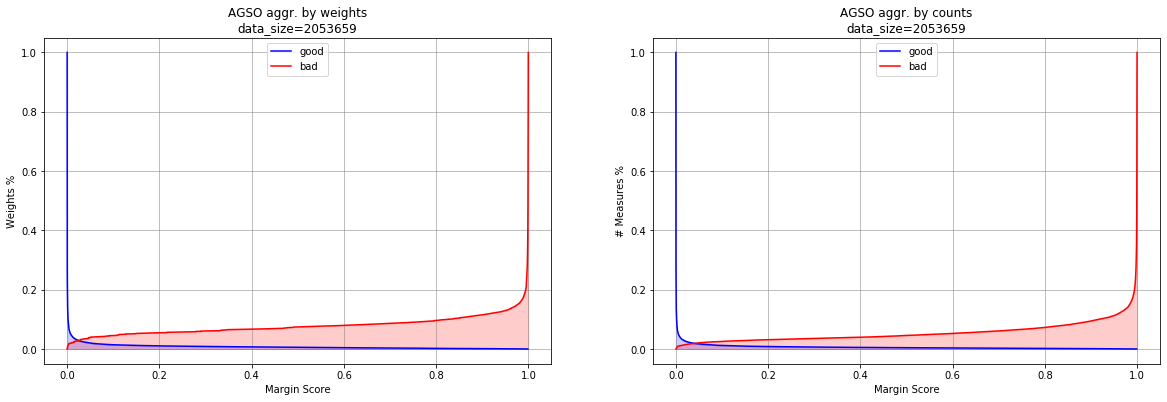

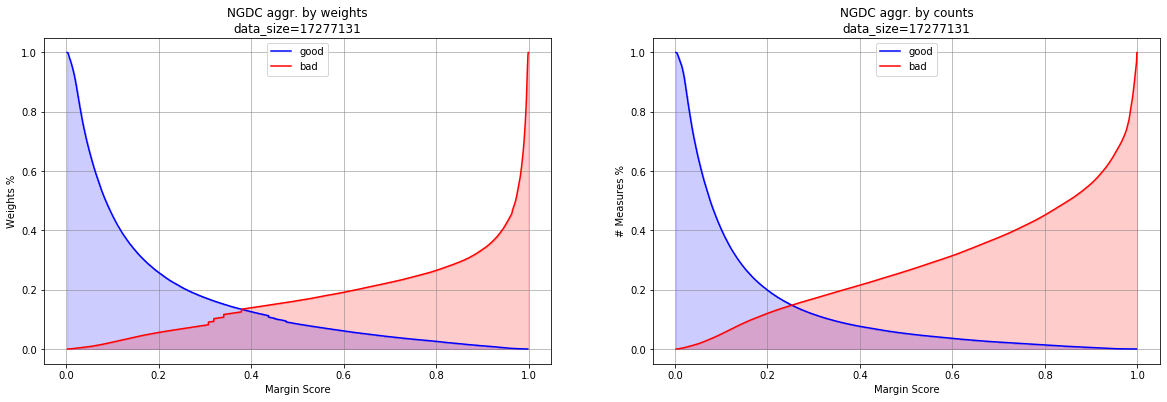

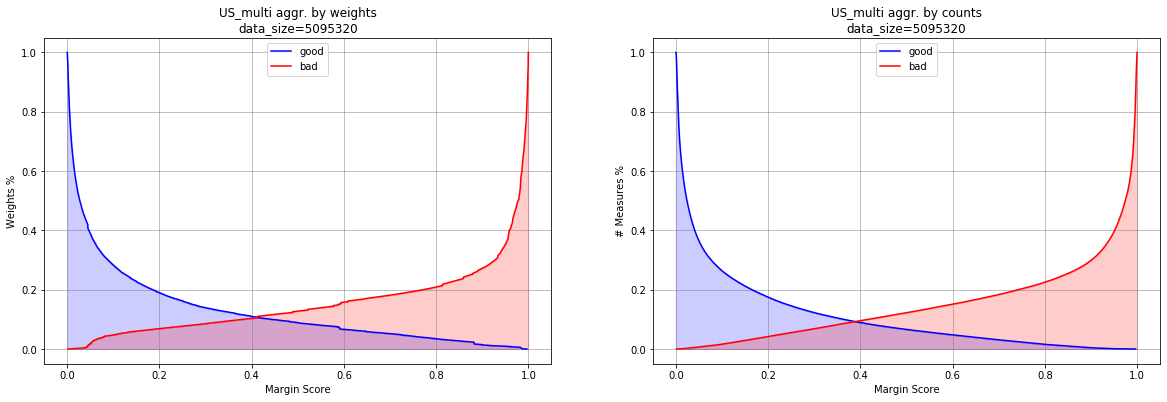

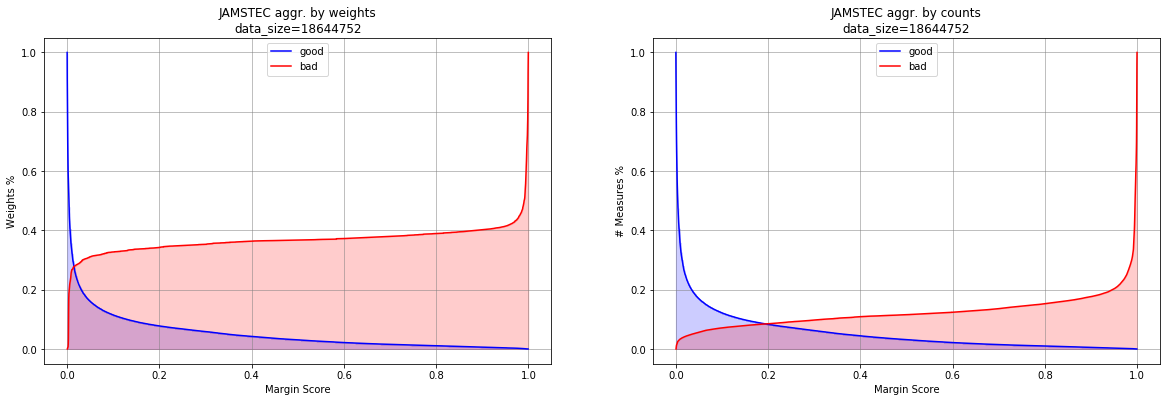

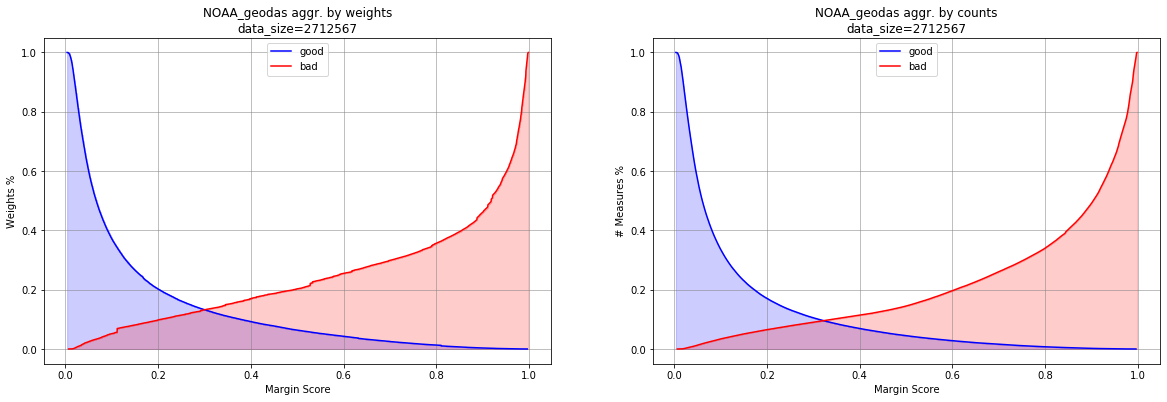

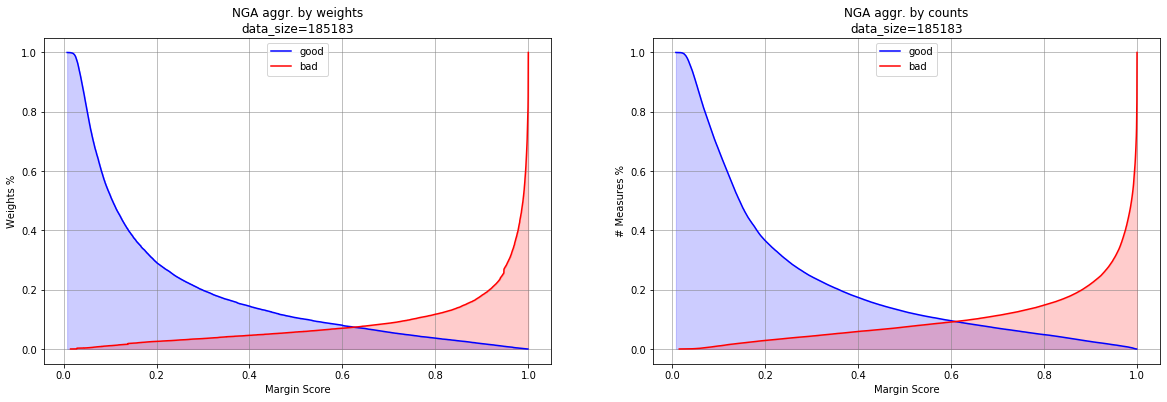

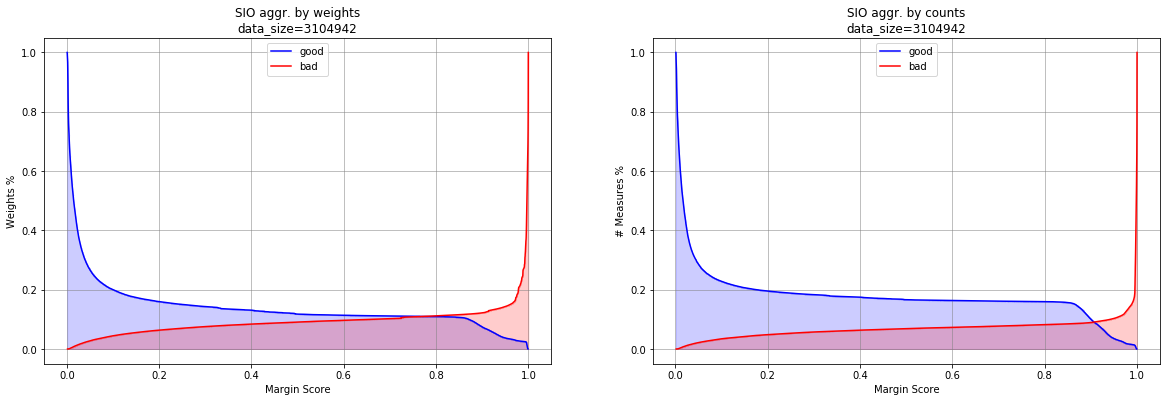

In [71]:
print("{0:12s}\t{1:4s}\t{2:4s}".format("Scores range", "min", "max"))
for source in sources:
    path = os.path.join(base_dir, "{}_scores.pkl".format(source))
    with open(path, 'rb') as f:
        data = pickle.load(f)
        _, _, scores, _ = data
        print("{0:12s}\t{1:.2f}\t{2:.2f}".format(source, np.min(scores), np.max(scores)))
        plot_scores(data, source)